In [1]:
from gym import parallel_state, GameState, parallel_step_ignore_finished, parallel_reset
import numpy as np
import numba as nb
import tensorflow as tf
# Optional: Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
import json
import models
from gym import visualize_state

2024-12-21 00:21:58.009782: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 00:21:58.032497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 00:21:58.032520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 00:21:58.033363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 00:21:58.037541: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


2024-12-21 00:21:59.804000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-21 00:21:59.834132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-21 00:21:59.834300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Name of the log to test (e.g. logs/weapon6 => weapon6)

In [2]:
test_name = 'weapon6'

In [4]:
with open(f'logs/{test_name}/config.json') as f:
    config = json.load(f)
model = getattr(models, config['model_name'])(**config['model_kwargs'])
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(tf.train.latest_checkpoint(f'logs/{test_name}/checkpoints/'))

2024-12-21 00:22:35.017415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-21 00:22:35.017593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-21 00:22:35.017692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Number of games to test (e.g. 1000)
- Note: All games are created at the same time, so too large number of games requires a lot of memory.
- Note: GameStates are numba.jit compiled, so it may take a while to compile.

In [5]:
EVAL_N = 2000

In [6]:
states = nb.typed.List([GameState(
    boardsize=8,
    max_chance=8,
    immutable_idx_list=np.array([
                56,
                57,
                58,
                61,
                62,
                63,
                48,
                49,
                54,
                55,
                40,
                47,
                16,
                23,
                8,
                9,
                14,
                15,
                0,
                1,
                2,
                5,
                6,
                7
            ],dtype=np.int32),
    chaos_idx_list=np.array([
                42,
                45,
                52,
                37,
                26,
                18,
                21,
                11
            ],np.int32),
    chogibaek=0,
    ) for _ in range(EVAL_N)])

In [12]:
parallel_reset(states)
output_state_array, output_mask_array, output_finished_array, output_successed_array = parallel_state(states)
while not np.all(output_finished_array):
    action_logits = model.predict(output_state_array, batch_size=1000)
    action_logits[np.logical_not(output_mask_array)] = -np.inf
    actions = np.argmax(action_logits, axis=-1)
    output_state_array, output_mask_array, output_finished_array, output_successed_array = parallel_step_ignore_finished(states, actions)
print(np.mean(output_successed_array))

2/2 [==============================] - 0s 36ms/step
0.1445


In [16]:
success_indices = np.nonzero(output_successed_array)[0]
print('Successed indices:', *success_indices[:10])

Successed indices: 2 10 39 42 44 56 75 96 108 111


### Choose the index of the game to visualize (e.g. 0)

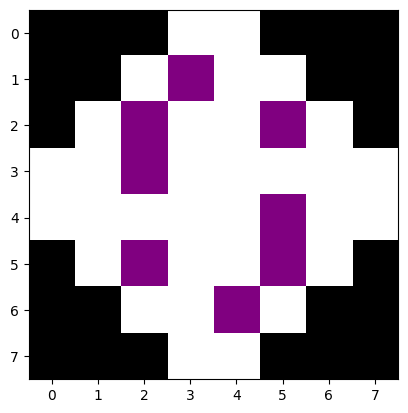

남은 기회: 8
무기 교체 가능 횟수: 2
현재 무기: 충격파 폭풍우
다음 무기: 해일 용오름 용오름
--------------------
특수 타일: 남은 정령이 소환한 정령으로 복제 

무기 1: 폭풍우


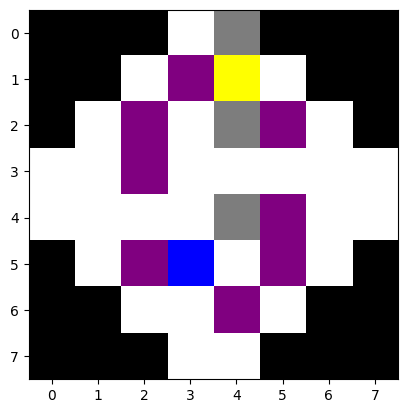

남은 기회: 7
무기 교체 가능 횟수: 2
현재 무기: 충격파 용오름
다음 무기: 용오름 해일 용오름
--------------------
특수 타일: 남은 정령이 분출(120) or 세계수 공명(121)으로 변환 

무기 0: 충격파


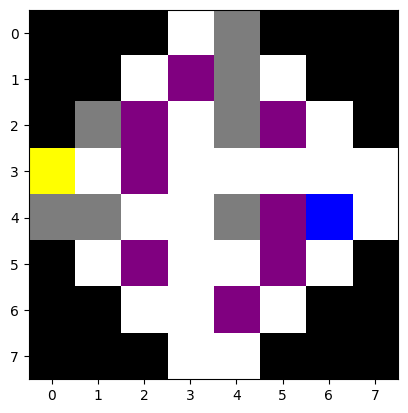

남은 기회: 6
무기 교체 가능 횟수: 2
현재 무기: 해일 용오름(2단계)
다음 무기: 지진 낙뢰 용오름
--------------------
특수 타일: 남은 정령이 분출(120) or 세계수 공명(121)으로 변환 

무기 0: 해일


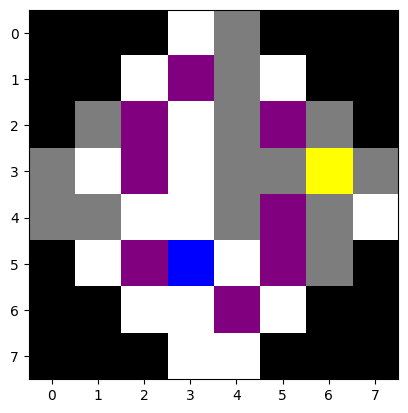

남은 기회: 5
무기 교체 가능 횟수: 2
현재 무기: 용오름 분출
다음 무기: 벼락 지진 낙뢰
--------------------
특수 타일: 남은 정령이 소환한 정령으로 복제 

무기 0: 용오름


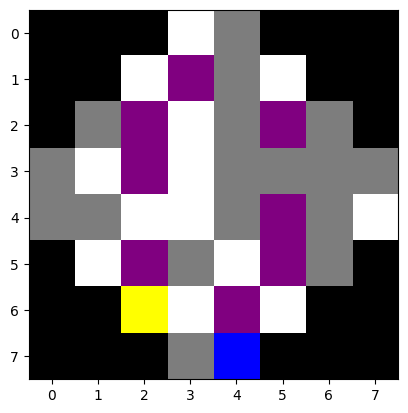

남은 기회: 4
무기 교체 가능 횟수: 2
현재 무기: 낙뢰 세계수의 공명
다음 무기: 벼락 벼락 지진
--------------------
특수 타일: 남아 있는 모든 석판이 재배치 

무기 1: 세계수의 공명


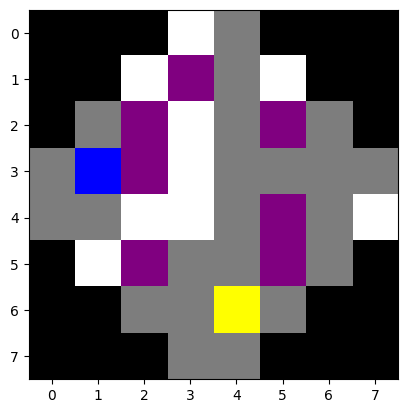

남은 기회: 3
무기 교체 가능 횟수: 2
현재 무기: 지진 세계수의 공명
다음 무기: 용오름 벼락 벼락
--------------------
특수 타일: 남은 정령이 소환한 정령으로 복제 

무기 1: 세계수의 공명


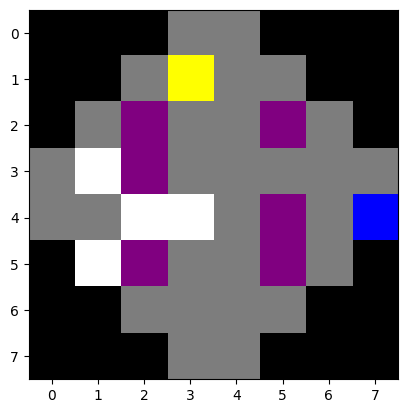

남은 기회: 2
무기 교체 가능 횟수: 2
현재 무기: 벼락 지진
다음 무기: 충격파 용오름 벼락
--------------------
특수 타일: 남은 정령이 소환한 정령으로 복제 

무기 1 교체


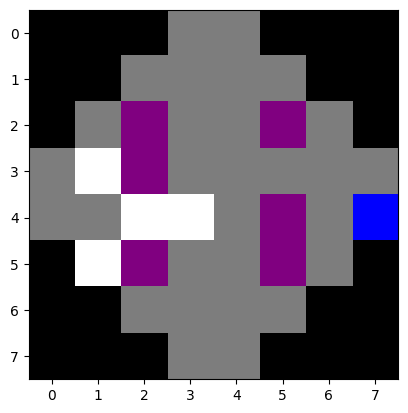

남은 기회: 2
무기 교체 가능 횟수: 1
현재 무기: 용오름 벼락(2단계)
다음 무기: 용오름 용오름 충격파
--------------------
특수 타일: 정령 교체 가능 횟수 증가 

무기 1: 벼락(2단계)


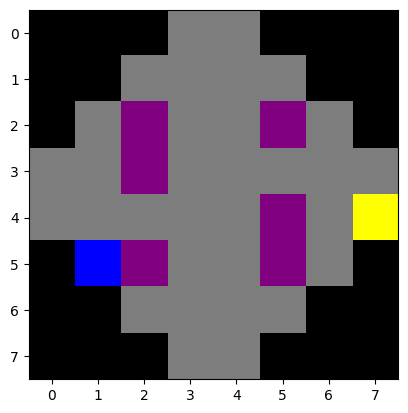

남은 기회: 1
무기 교체 가능 횟수: 1
현재 무기: 충격파 벼락(2단계)
다음 무기: 대폭발 용오름 용오름
--------------------
특수 타일: 정령 교체 가능 횟수 증가 

무기 0 교체


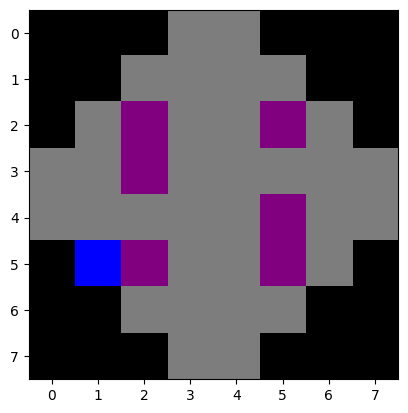

남은 기회: 1
무기 교체 가능 횟수: 0
현재 무기: 용오름 벼락(2단계)
다음 무기: 업화 대폭발 용오름
--------------------
마지막 행동: 41


In [17]:
IDX = 2

sample_history, sample_actions = states[IDX].get_history()
sample_actions.insert(0, None)
last_s = None
for s, a in zip(sample_history, sample_actions):
    visualize_state((s, None), a, last_s)
    last_s = s
print(f'마지막 행동: {sample_actions[-1]}')